In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.transforms import v2
from torchvision import datasets, models, transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import shutil
from sklearn.model_selection import train_test_split


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import time

from PIL import Image
import zipfile
from tqdm import tqdm

# Формирование датасета

In [2]:
! kaggle datasets download -d kunalgupta2616/dog-vs-cat-images-data

# Распакуем архив
with zipfile.ZipFile("dog-vs-cat-images-data.zip", 'r') as zip_ref:
  zip_ref.extractall("dog-vs-cat-images")

Dataset URL: https://www.kaggle.com/datasets/kunalgupta2616/dog-vs-cat-images-data
License(s): GPL-2.0
dog-vs-cat-images-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Пути к папкам с исходными данными
train_dir = 'dog-vs-cat-images/dogcat/train'
validation_dir = 'dog-vs-cat-images/dogcat/validation'
test_dir = 'dog-vs-cat-images/dogcat/test1'
all_data_dir = 'dog-vs-cat-images/dogcat'

# 1. Объединение train и validation

# Новая папка для объединенных данных
combined_dir = 'dog-vs-cat-images/combined'
os.makedirs(combined_dir, exist_ok=True)

# Подпапки dogs и cats в объединенной папке
os.makedirs(os.path.join(combined_dir, 'dogs'), exist_ok=True)
os.makedirs(os.path.join(combined_dir, 'cats'), exist_ok=True)

# Изображения из папок train и validation в объединенную папку
for category in ['dogs', 'cats']:
  for source_dir in [train_dir, validation_dir]:
    source_path = os.path.join(source_dir, category)
    for filename in os.listdir(source_path):
      source_file = os.path.join(source_path, filename)
      destination_file = os.path.join(combined_dir, category, filename)
      shutil.move(source_file, destination_file)

# 2. Удаление лишние папки
shutil.rmtree(all_data_dir)

In [4]:
# делим данные на train, val, test
DATA_ROOT = 'dog-vs-cat-images/combined'
OUTPUT_DIR = 'data'

def DataSplitter(data_root, output_dir, train_size=0.6, valid_size=0.2, test_size=0.2):
  classes = ['dogs', 'cats']
  for phase in ['train', 'valid', 'test']:
    for class_name in classes:
      os.makedirs(os.path.join(output_dir, phase, class_name), exist_ok=True)

  for class_name in classes:
    class_dir = os.path.join(data_root, class_name)
    images = os.listdir(class_dir)

    if not images:
      print(f"Изображений в {class_dir} нет!")
      continue

    # делим на train  и "остальные"
    train_imgs, temp_imgs = train_test_split(images, train_size=train_size, random_state=0)
    # "остальные" делим на valid и test
    valid_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_size/(test_size + valid_size), random_state=0)

    for img in train_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'train', class_name, img))

    for img in valid_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'valid', class_name, img))

    for img in test_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'test', class_name, img))

# Финальное формирование датасета
DataSplitter(DATA_ROOT, OUTPUT_DIR)

# Удаление источника данных
shutil.rmtree('dog-vs-cat-images')

## Посмотрим по 1 примеру из каждого класса

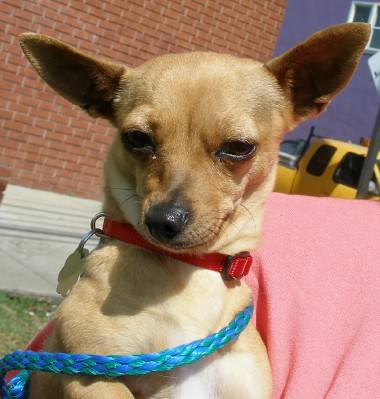

In [5]:
dog_dirr = os.path.join(OUTPUT_DIR, 'train/dogs')
Image.open(os.path.join(dog_dirr, os.listdir(dog_dirr)[100]))

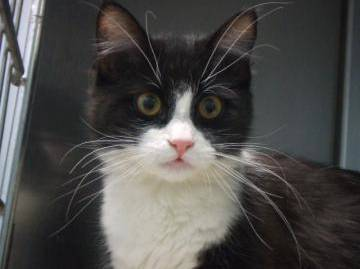

In [6]:
cat_dirr = os.path.join(OUTPUT_DIR, 'train/cats')
Image.open(os.path.join(cat_dirr, os.listdir(cat_dirr)[10]))

### Данных немного => обогатим датасет за счет аугментации

In [7]:
# трансформации для увеличения данных
image_transforms = {
    # обрезка + масштабирование; поворот; переворот; обрезка; нормализация как для ResNet
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    # масштабирование; нормализация
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    # масштабирование; нормализация'''
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}


### Загрузка данных

In [8]:
train_dir = f'{OUTPUT_DIR}/train'
val_dir = f'{OUTPUT_DIR}/valid'
test_dir = f'{OUTPUT_DIR}/test'

data = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=val_dir, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}

# проверим, что классы сбалансированы
print(f"Количество изображений кошек в трейне: {data['train'].targets.count(0)}")
print(f"Количество изображений собак в трейне: {data['train'].targets.count(1)}")

Количество изображений кошек в трейне: 7500
Количество изображений собак в трейне: 7500


In [9]:
# Подгружать данные будем по небольшим батчам
BATCH_SIZE = 4

train_data = DataLoader(data['train'], batch_size=BATCH_SIZE, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=BATCH_SIZE, shuffle=True)
test_data = DataLoader(data['test'], batch_size=BATCH_SIZE, shuffle=True)

# Объемы датасетов
print(f'''Объемы датасетов:
train: {len(data['train'])}
val: {len(data['valid'])}
test: {len(data['test'])}
      ''')

Объемы датасетов:
train: 15000
val: 5000
test: 5000
      


# 1. Resnet34

In [10]:
resnet = models.resnet34(pretrained=True) # Загрузка предобученной модели ResNet152

# Заморозка параметров модели
for param in resnet.parameters():
    param.requires_grad = False

# Последний полносвязный слой меняем для бинарной классификации
fc_inputs = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),  # Новый полносвязный слой с 256 нейронами
    nn.ReLU(),                  # ReLU-активация
    nn.Dropout(0.4),            # регуляризация DropOut
    nn.Linear(256, 1)  # Выходной слой
)

# print(resnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 143MB/s]


In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
resnet = resnet.to(DEVICE)

NUM_EPOCHS = 20
CRITERION = nn.BCEWithLogitsLoss() # loss-функция: бинарная кросс-энтропия, объединенная с сигмоидой
OPTIMIZER = optim.Adam(resnet.parameters(), lr=0.0001) # оптимизатор: Adam


In [12]:
# функции обучения и валидации модели
def train_model(model=resnet, train_loader=train_data, criterion=CRITERION, optimizer=OPTIMIZER, device=DEVICE):
    model.train()
    train_loss = 0.0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        loss = criterion(model(inputs), labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)



def validate_model(model=resnet, valid_loader=valid_data, criterion=CRITERION, device=DEVICE):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            loss = criterion(model(inputs), labels.float().unsqueeze(1))
            val_loss += loss.item()

    return val_loss / len(valid_loader)

100%|██████████| 3750/3750 [01:53<00:00, 33.06it/s]


epoch 1/20, 	 train_loss: 0.2766, 	 val_loss: 0.0902


100%|██████████| 3750/3750 [01:51<00:00, 33.58it/s]


epoch 2/20, 	 train_loss: 0.2468, 	 val_loss: 0.0678


100%|██████████| 3750/3750 [01:51<00:00, 33.68it/s]


epoch 3/20, 	 train_loss: 0.2305, 	 val_loss: 0.0667


100%|██████████| 3750/3750 [01:49<00:00, 34.17it/s]


epoch 4/20, 	 train_loss: 0.2202, 	 val_loss: 0.0590


100%|██████████| 3750/3750 [01:49<00:00, 34.33it/s]


epoch 5/20, 	 train_loss: 0.1984, 	 val_loss: 0.0581


100%|██████████| 3750/3750 [01:48<00:00, 34.51it/s]


epoch 6/20, 	 train_loss: 0.1915, 	 val_loss: 0.0474


100%|██████████| 3750/3750 [01:50<00:00, 33.89it/s]


epoch 7/20, 	 train_loss: 0.1866, 	 val_loss: 0.0436


100%|██████████| 3750/3750 [01:50<00:00, 33.82it/s]


epoch 8/20, 	 train_loss: 0.1768, 	 val_loss: 0.0507


100%|██████████| 3750/3750 [01:49<00:00, 34.17it/s]


epoch 9/20, 	 train_loss: 0.1727, 	 val_loss: 0.0447


100%|██████████| 3750/3750 [01:49<00:00, 34.20it/s]


epoch 10/20, 	 train_loss: 0.1641, 	 val_loss: 0.0427


100%|██████████| 3750/3750 [01:48<00:00, 34.47it/s]


epoch 11/20, 	 train_loss: 0.1610, 	 val_loss: 0.0438


100%|██████████| 3750/3750 [01:59<00:00, 31.49it/s]


epoch 12/20, 	 train_loss: 0.1566, 	 val_loss: 0.0487


100%|██████████| 3750/3750 [01:54<00:00, 32.82it/s]


epoch 13/20, 	 train_loss: 0.1499, 	 val_loss: 0.0488


100%|██████████| 3750/3750 [01:50<00:00, 33.85it/s]


epoch 14/20, 	 train_loss: 0.1437, 	 val_loss: 0.0526


100%|██████████| 3750/3750 [01:50<00:00, 33.93it/s]


epoch 15/20, 	 train_loss: 0.1405, 	 val_loss: 0.0509


100%|██████████| 3750/3750 [01:50<00:00, 34.01it/s]


epoch 16/20, 	 train_loss: 0.1440, 	 val_loss: 0.0635


100%|██████████| 3750/3750 [01:50<00:00, 34.07it/s]


epoch 17/20, 	 train_loss: 0.1370, 	 val_loss: 0.0573


100%|██████████| 3750/3750 [01:50<00:00, 33.80it/s]


epoch 18/20, 	 train_loss: 0.1398, 	 val_loss: 0.0427


100%|██████████| 3750/3750 [01:49<00:00, 34.37it/s]


epoch 19/20, 	 train_loss: 0.1357, 	 val_loss: 0.0412


100%|██████████| 3750/3750 [01:49<00:00, 34.20it/s]


epoch 20/20, 	 train_loss: 0.1244, 	 val_loss: 0.0444


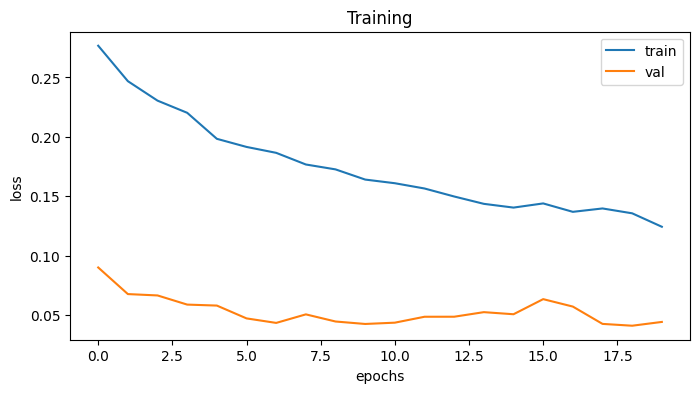

In [13]:
# непосредственно обучение модели
train_losses, val_losses  = [], []

for epoch in range(NUM_EPOCHS):
    # start_time = time.time()
    train_loss = train_model()
    val_loss = validate_model()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # end_time = time.time()
    # epoch_time = end_time - start_time
    # print(f'epoch {epoch+1}/{NUM_EPOCHS}, \t train_loss: {train_loss:.4f}, \t val_loss: {val_loss:.4f}, \t time: {epoch_time:.4f}')
    print(f'epoch {epoch+1}/{NUM_EPOCHS}, \t train_loss: {train_loss:.4f}, \t val_loss: {val_loss:.4f}')

# График
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training')
plt.legend()
plt.show()

### Оценим качество модели на тестовой выборке

In [14]:
def eval_model(model=resnet, test_loader=test_data, device=DEVICE):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            preds = torch.sigmoid(model(inputs)).round()
            all_preds.extend(preds.cpu().numpy())  # предсказанные лейблы
            all_labels.extend(labels.cpu().numpy())  # true лейблы


    all_preds, all_labels = np.array(all_preds), np.array(all_labels)

    # метрики
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    print(f'''
    accuracy on test: {accuracy:.4f}
    precision on test: {precision:.4f}
    recall on test: {recall:.4f}
    ''')


# непосредственно оценка
eval_model()

100%|██████████| 1250/1250 [00:30<00:00, 41.04it/s]


    accuracy on test: 0.9804
    precision on test: 0.9740
    recall on test: 0.9872
    


## Посмотрим как классифицируются изображения

In [15]:
# для отрисовки картинки
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    # средние и std для ResNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


# для отрисовки сразу нескольких картинок
def display_preds(model=resnet, test_loader=test_data, device=DEVICE, num_displays=3):
    """Функция для отображения нескольких изображений и предсказаний"""
    model.eval()
    num_shown = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs).round()

            for i in range(inputs.size(0)):
                if num_shown == num_displays:
                    return
                imshow(inputs[i].cpu(), title=f"predicted class: {int(preds[i].item())}, true class: {labels[i].item()}")
                num_shown += 1



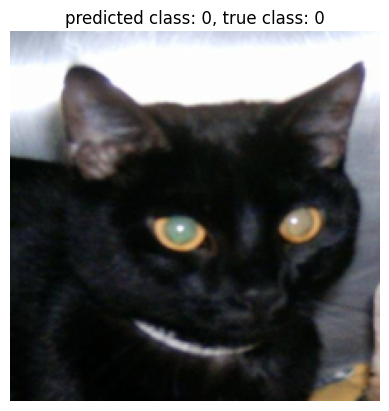

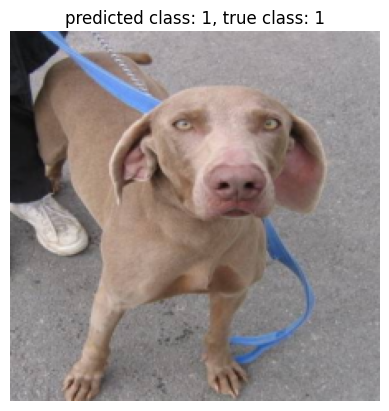

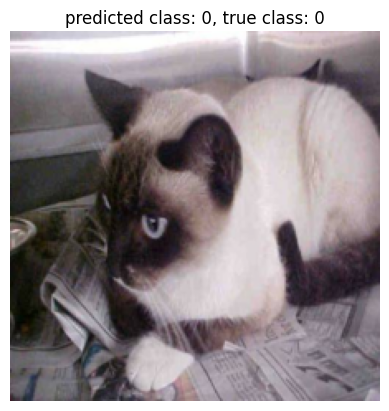

In [16]:
display_preds(num_displays=3)


# 2. EfficientNetB2

In [17]:
efficientnet = models.efficientnet_b2(pretrained=True)

# Заморозка параметров модели
for param in efficientnet.parameters():
    param.requires_grad = False

# Последний полносвязный слой меняем для бинарной классификации
fc_inputs = efficientnet.classifier[1].in_features
efficientnet.classifier = nn.Sequential(
    nn.Linear(fc_inputs, 256),  # Новый полносвязный слой с 256 нейронами
    nn.ReLU(),                  # ReLU-активация
    nn.Dropout(0.4),            # регуляризация DropOut
    nn.Linear(256, 1)  # Выходной слой
)

# print(efficientnet)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 88.9MB/s]


In [18]:
efficientnet = efficientnet.to(DEVICE)

EPOCHS = 20
CRITERION = nn.BCEWithLogitsLoss()
OPTIMIZER = optim.Adam(efficientnet.parameters(), lr=0.001)

100%|██████████| 3750/3750 [02:26<00:00, 25.63it/s]


epoch 1/20, 	 train_loss: 0.2536, 	 val_loss: 0.1273


100%|██████████| 3750/3750 [02:25<00:00, 25.79it/s]


epoch 2/20, 	 train_loss: 0.2372, 	 val_loss: 0.1122


100%|██████████| 3750/3750 [02:29<00:00, 25.16it/s]


epoch 3/20, 	 train_loss: 0.2255, 	 val_loss: 0.1011


100%|██████████| 3750/3750 [02:29<00:00, 25.10it/s]


epoch 4/20, 	 train_loss: 0.2145, 	 val_loss: 0.0993


100%|██████████| 3750/3750 [02:26<00:00, 25.62it/s]


epoch 5/20, 	 train_loss: 0.2089, 	 val_loss: 0.1449


100%|██████████| 3750/3750 [02:24<00:00, 25.97it/s]


epoch 6/20, 	 train_loss: 0.2024, 	 val_loss: 0.1281


100%|██████████| 3750/3750 [02:26<00:00, 25.63it/s]


epoch 7/20, 	 train_loss: 0.2032, 	 val_loss: 0.1129


100%|██████████| 3750/3750 [02:23<00:00, 26.06it/s]


epoch 8/20, 	 train_loss: 0.1987, 	 val_loss: 0.1027


100%|██████████| 3750/3750 [02:22<00:00, 26.32it/s]


epoch 9/20, 	 train_loss: 0.1986, 	 val_loss: 0.1141


100%|██████████| 3750/3750 [02:22<00:00, 26.26it/s]


epoch 10/20, 	 train_loss: 0.1972, 	 val_loss: 0.1069


100%|██████████| 3750/3750 [02:22<00:00, 26.33it/s]


epoch 11/20, 	 train_loss: 0.1834, 	 val_loss: 0.1061


100%|██████████| 3750/3750 [02:24<00:00, 26.01it/s]


epoch 12/20, 	 train_loss: 0.1885, 	 val_loss: 0.1000


100%|██████████| 3750/3750 [02:25<00:00, 25.76it/s]


epoch 13/20, 	 train_loss: 0.1836, 	 val_loss: 0.1220


100%|██████████| 3750/3750 [02:23<00:00, 26.13it/s]


epoch 14/20, 	 train_loss: 0.1861, 	 val_loss: 0.1225


100%|██████████| 3750/3750 [02:22<00:00, 26.37it/s]


epoch 15/20, 	 train_loss: 0.1803, 	 val_loss: 0.1092


100%|██████████| 3750/3750 [02:23<00:00, 26.11it/s]


epoch 16/20, 	 train_loss: 0.1779, 	 val_loss: 0.1295


100%|██████████| 3750/3750 [02:24<00:00, 25.98it/s]


epoch 17/20, 	 train_loss: 0.1786, 	 val_loss: 0.1047


100%|██████████| 3750/3750 [02:22<00:00, 26.28it/s]


epoch 18/20, 	 train_loss: 0.1734, 	 val_loss: 0.1143


100%|██████████| 3750/3750 [02:22<00:00, 26.34it/s]


epoch 19/20, 	 train_loss: 0.1690, 	 val_loss: 0.1361


100%|██████████| 3750/3750 [02:23<00:00, 26.05it/s]


epoch 20/20, 	 train_loss: 0.1662, 	 val_loss: 0.1249


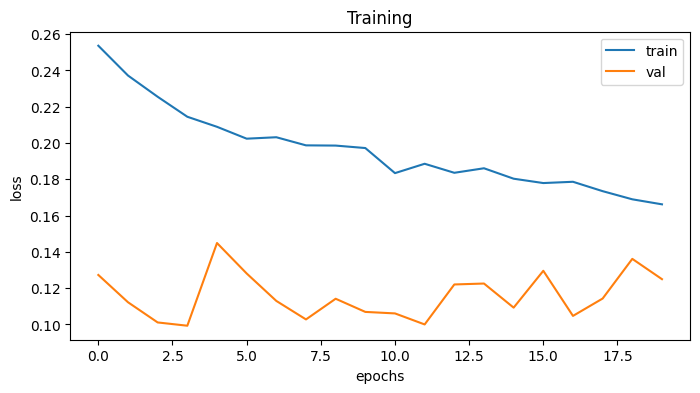

In [19]:
# обучение модели
train_model(model=efficientnet, train_loader=train_data, criterion=CRITERION, optimizer=OPTIMIZER, device=DEVICE)


# непосредственно обучение модели
train_losses, val_losses  = [], []

for epoch in range(NUM_EPOCHS):
    # start_time = time.time()
    train_loss = train_model(model=efficientnet, train_loader=train_data, criterion=CRITERION, optimizer=OPTIMIZER, device=DEVICE)
    val_loss = validate_model(model=efficientnet, valid_loader=valid_data, criterion=CRITERION, device=DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    # end_time = time.time()
    # epoch_time = end_time - start_time
    # print(f'epoch {epoch+1}/{NUM_EPOCHS}, \t train_loss: {train_loss:.4f}, \t val_loss: {val_loss:.4f}, \t time: {epoch_time:.4f}')
    print(f'epoch {epoch+1}/{NUM_EPOCHS}, \t train_loss: {train_loss:.4f}, \t val_loss: {val_loss:.4f}')

# График
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training')
plt.legend()
plt.show()

In [20]:
# оценка на тестовой выборке
eval_model(model=efficientnet, test_loader=test_data, device=DEVICE)

100%|██████████| 1250/1250 [00:36<00:00, 33.98it/s]


    accuracy on test: 0.9576
    precision on test: 0.9438
    recall on test: 0.9732
    


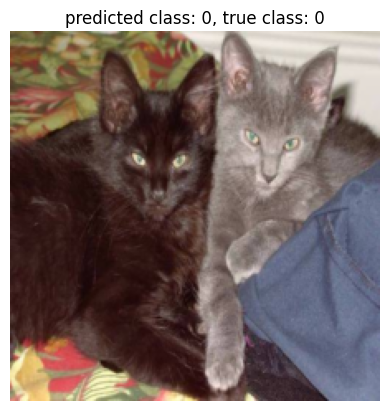

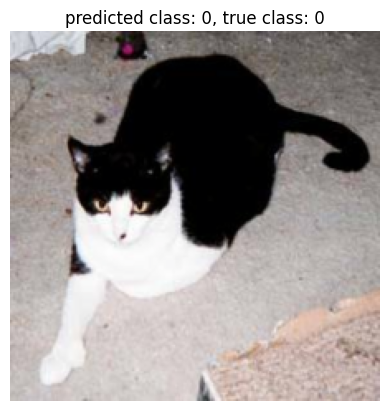

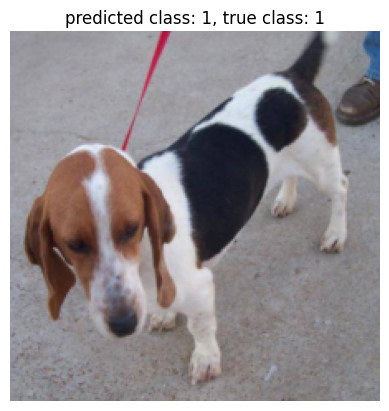

In [21]:
# посмотрим как классифицируются изображения
display_preds(model=resnet, test_loader=test_data, device=DEVICE, num_displays=3)

мы видим, что модель efficientnet, в отличии от resnet:
- менее стабильно делает предсказания;
- начинает переобучаться с 11 эпохи
- показывает loss выше чем resnet на валиде

Метрики на test вышли похуже, чем у resnet.
- 0.9515 на Accuracy у efficientnet против 0.9806 у resnet
- Precision равные у моделей efficientnet и resnet
- 0.9238 на Recall у efficientnet против 0.9905 у resnet

То есть, модель делает ошибку на подсолнухах: предсказывает класс 0 вместо класса 1

# Вывод

Мы сравнили 2 предобученные на Imagenet модели: resnet50 и EfficientNet-B0.
В результате finetune на задачу бинарное классификации подсолнухов и роз, мы пришли к следующим результатам:

Resnet50
- Test Accuracy: 0.9806
- Test Precision: 0.9720
- Test Recall: 0.9905

EfficientNet-B0
- Test Accuracy: 0.9515
- Test Precision: 0.9798
- Test Recall: 0.9238

Из интересного необходимо отметить, что процесс тюнинга Resnet50 выглядит стабильнее, модель быстро вышла на плато. EfficientNet-B0 в свою очередь начала переобучаться на середине обучения. Почему Resnet50 показала лучше результаты? Потому что resnet сама по себе модель более глубокая, "тяжелая", поэтому она способна улавливать более сложные зависимости в данных. У resnet50, исходя из документации, 25.5 млн. параметров, когда у EfficientNet-B0 всего 5 млн.